# Черновой вариант решения задачи об оценке стоимости автомобиля
## Общая обзорная часть

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 50) 
cars = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\200618_auto_bd_100_do_Ekata.csv", sep=';', encoding='utf-8')
# cars = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\auto_bd_50_do_niznego.csv", sep=';', encoding='utf-8')
cars1 = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\auto_bd.100_do_Rostova.csv", sep=';', encoding='utf-8')
cars2 = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\auto_bd.csv", sep=';', encoding='utf-8')
cars = pd.concat([cars, cars1, cars2], ignore_index=True)
cars.drop_duplicates(inplace=True)
cars.reset_index(inplace=True)
cars.to_csv('d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\200620_auto_bd_100_merged.csv', sep=';', encoding='utf-8')
cars.head(5)

,index,brand,name,modelDate,color,productionDate,bodyType,fuelType,numberOfDoors,vehicleConfiguration,vehicleTransmission,engineDisplacement,whilleType,drive,enginePower,href,kmAge,place,VIN,seller,#owners,inUse,pts,condition,tax,castoms,exchange,price,priceCurrency
0,0,SKODA,Skoda Octavia III (A7),2013,чёрный,2015,универсал 5 дв.,бензин,5,WAGON_5_DOORS ROBOT 1.8,роботизированная,1.8 LTR,Левый,полный,180 N12,https://auto.ru/cars/used/sale/skoda/octavia/1...,116 000 км,Пушкино,TMB**************,Private,1 владелец,0,Оригинал,Не требует ремонта,8 820 ₽ / год,Растаможен,NaN,1350000,RUB
1,1,FORD,Ford Focus II Рестайлинг,2007,чёрный,2008,седан,бензин,4,SEDAN MECHANICAL 1.8,механическая,1.8 LTR,Левый,передний,125 N12,https://auto.ru/cars/used/sale/ford/focus/1098...,152 000 км,Москва,WF0**************,АЦ на Варшавке,3 или более,0,Оригинал,Не требует ремонта,3 125 ₽ / год,Растаможен,Рассмотрю варианты,319000,RUB
2,2,BMW,BMW X3 II (F25) 20d xDrive,2010,синий,2014,внедорожник 5 дв.,дизель,5,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,2.0 LTR,Левый,полный,184 N12,https://auto.ru/cars/used/sale/bmw/x3/10985290...,134 215 км,Москва,X4X**************,Private,1 владелец,0,Оригинал,Не требует ремонта,9 200 ₽ / год,Растаможен,NaN,1271000,RUB
3,3,VAZ,LADA (ВАЗ) Kalina I,2004,чёрный,2009,универсал 5 дв.,бензин,5,WAGON_5_DOORS MECHANICAL 1.6,механическая,1.6 LTR,Левый,передний,81 N12,https://auto.ru/cars/used/sale/vaz/kalina/1098...,17 372 км,Москва,XTA**************,Private,2 владельца,0,Оригинал,Не требует ремонта,972 ₽ / год,Растаможен,Рассмотрю варианты,300000,RUB
4,4,AUDI,Audi Q7 II (4M) Рестайлинг 45 TDI,2019,коричневый,2020,внедорожник 5 дв.,дизель,5,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,NaN,Полный,249 N12,https://auto.ru/cars/new/group/audi/q7/2190500...,Новый,Москва,NaN,Ауди Центр Таганка,0,0,NaN,NaN,18 675 ₽ / год,NaN,NaN,4805000,RUB


In [2]:
# Функция для вывода со статисчтической иноформацией о признаке
def feature_info(_column, _bins = 0, _normalize=True, _values=False, _threshold=10):
    
    if(_bins==0):
        _bins = len(_column.value_counts(dropna=True, normalize=_normalize))
            
    print(f"Тип признака: {_column.dtype}\nЗначения признака:")
    
    
    if _column.dtype != 'object':
        _column.hist(bins = _bins, align='left')
        display(_column.describe())
        if _values == True:
            display(pd.DataFrame(_column.value_counts(dropna=False, normalize=_normalize).round(3)))
       # plt.plot(_column,pupils['score'])
    
    else:
        display(pd.DataFrame(_column.value_counts(dropna=False, normalize=_normalize).round(3)))
    
    print(f"Различных значений c учётом NaN: {len(_column.value_counts(dropna=False, normalize=_normalize))}\n\
              \t  без учёта NaN: {len(_column.value_counts(dropna=True, normalize=_normalize))} \nПропусков: {_column.isnull().sum()}")
    print(f"Значений, встретившихся в столбце более {_threshold} раз:"#Число 10 взято для ориентира, можно брать другое
      , (_column.value_counts()>_threshold).sum())
    

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85077 entries, 0 to 85076
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 85077 non-null  int64 
 1   brand                 85077 non-null  object
 2   name                  85077 non-null  object
 3   modelDate             85077 non-null  int64 
 4   color                 85077 non-null  object
 5   productionDate        85077 non-null  int64 
 6   bodyType              85077 non-null  object
 7   fuelType              85077 non-null  object
 8   numberOfDoors         85077 non-null  int64 
 9   vehicleConfiguration  85077 non-null  object
 10  vehicleTransmission   85077 non-null  object
 11  engineDisplacement    85077 non-null  object
 12  whilleType            72513 non-null  object
 13  drive                 85021 non-null  object
 14  enginePower           85077 non-null  object
 15  href                  85077 non-null

### brand

In [4]:
feature_info(cars.brand, _normalize=False, _threshold=100)

Тип признака: object
Значения признака:


,brand
VAZ,12101
HYUNDAI,6272
KIA,6219
TOYOTA,5224
NISSAN,4924
...,...
TIANMA,1
SAMSUNG,1
ZIS,1
LUXGEN,1


Различных значений c учётом NaN: 109
              	  без учёта NaN: 109 
Пропусков: 0
Значений, встретившихся в столбце более 100 раз: 42


### name

In [5]:
feature_info(cars.name, _normalize=False, _threshold=100)

Тип признака: object
Значения признака:


,name
LADA (ВАЗ) Granta I,1311
LADA (ВАЗ) Priora I,933
Chevrolet Niva I Рестайлинг,885
LADA (ВАЗ) Vesta I,845
Volkswagen Polo V Рестайлинг,818
...,...
Nissan Mistral,1
Mazda MPV III (LY),1
Mercedes-Benz G-Класс 4x4 II (W463) Рестайлинг 4 500 4x4,1
"Mercedes-Benz E-Класс II (W210, S210) Рестайлинг 430",1


Различных значений c учётом NaN: 3752
              	  без учёта NaN: 3752 
Пропусков: 0
Значений, встретившихся в столбце более 100 раз: 186


### modelDate

Тип признака: int64
Значения признака:


count    85077.000000
mean      2008.479201
std          7.922313
min       1935.000000
25%       2005.000000
50%       2010.000000
75%       2014.000000
max       2020.000000
Name: modelDate, dtype: float64

Различных значений c учётом NaN: 69
              	  без учёта NaN: 69 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 48


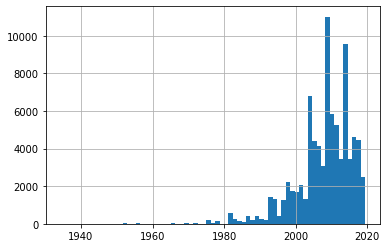

In [6]:
feature_info(cars.modelDate)

### color

In [7]:
feature_info(cars.color)

Тип признака: object
Значения признака:


,color
чёрный,0.219
белый,0.211
серебристый,0.150
серый,0.128
синий,0.083
красный,0.056
коричневый,0.045
зелёный,0.033
бежевый,0.026
голубой,0.016


Различных значений c учётом NaN: 16
              	  без учёта NaN: 16 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 16


### productionDate

Тип признака: int64
Значения признака:


count    85077.000000
mean      2011.523443
std          6.597838
min       1939.000000
25%       2008.000000
50%       2012.000000
75%       2017.000000
max       2020.000000
Name: productionDate, dtype: float64

Различных значений c учётом NaN: 72
              	  без учёта NaN: 72 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 41


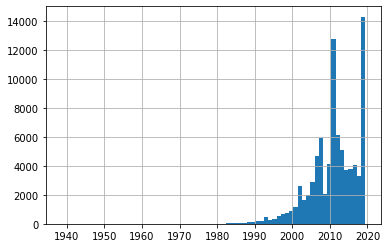

In [8]:
feature_info(cars.productionDate)

### bodyType

In [9]:
feature_info(cars.bodyType)

Тип признака: object
Значения признака:


,bodyType
седан,0.357
внедорожник 5 дв.,0.341
хэтчбек 5 дв.,0.143
универсал 5 дв.,0.048
лифтбек,0.033
компактвэн,0.017
хэтчбек 3 дв.,0.016
внедорожник 3 дв.,0.014
минивэн,0.013
купе,0.007


Различных значений c учётом NaN: 25
              	  без учёта NaN: 25 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 19


Есть отдельный признак, в котором хранится количество дверей, поэтому удалим его из этого признака

In [10]:
cars.bodyType = cars.bodyType.apply(lambda x: re.sub("\d дв\.", "", x))
feature_info(cars.bodyType)

Тип признака: object
Значения признака:


,bodyType
седан,0.357
внедорожник,0.355
хэтчбек,0.159
универсал,0.048
лифтбек,0.033
компактвэн,0.017
минивэн,0.013
купе,0.007
пикап двойная кабина,0.006
фургон,0.001


Различных значений c учётом NaN: 21
              	  без учёта NaN: 21 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 17


### fuelType  

In [11]:
feature_info(cars.fuelType)

Тип признака: object
Значения признака:


,fuelType
бензин,0.892
дизель,0.104
гибрид,0.003
электро,0.001
газ,0.000


Различных значений c учётом NaN: 5
              	  без учёта NaN: 5 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 5


### numberOfDoors

Тип признака: int64
Значения признака:


count    85077.000000
mean         4.541827
std          0.605684
min          0.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: numberOfDoors, dtype: float64

Различных значений c учётом NaN: 5
              	  без учёта NaN: 5 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 4


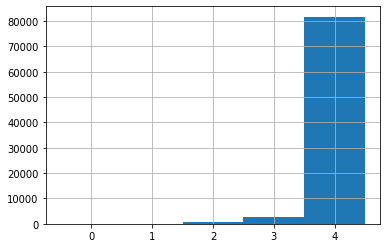

In [12]:
feature_info(cars.numberOfDoors)

### vehicleConfiguration

In [13]:
feature_info(cars.vehicleConfiguration)

Тип признака: object
Значения признака:


,vehicleConfiguration
SEDAN MECHANICAL 1.6,0.104
ALLROAD_5_DOORS AUTOMATIC 2.0,0.059
SEDAN AUTOMATIC 1.6,0.049
HATCHBACK_5_DOORS MECHANICAL 1.6,0.047
ALLROAD_5_DOORS AUTOMATIC 3.0,0.033
...,...
ALLROAD_5_DOORS VARIATOR 2.2,0.000
CABRIO AUTOMATIC 2.7,0.000
CABRIO MECHANICAL 3.0,0.000
PICKUP_ONE AUTOMATIC 4.7,0.000


Различных значений c учётом NaN: 739
              	  без учёта NaN: 739 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 328


Информация этого признака представлена другими отдельными признаками, поэтому его можно удалить

In [14]:
cars.drop(['vehicleConfiguration'], axis=1, inplace=True)

### vehicleTransmission

In [15]:
feature_info(cars.vehicleTransmission)

Тип признака: object
Значения признака:


,vehicleTransmission
механическая,0.440
автоматическая,0.418
вариатор,0.078
роботизированная,0.065


Различных значений c учётом NaN: 4
              	  без учёта NaN: 4 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 4


### engineDisplacement

In [16]:
feature_info(cars.engineDisplacement)

Тип признака: object
Значения признака:


,engineDisplacement
1.6 LTR,0.324
2.0 LTR,0.191
1.4 LTR,0.064
1.5 LTR,0.060
1.8 LTR,0.056
...,...
8.3 LTR,0.000
7.0 LTR,0.000
6.7 LTR,0.000
6.3 LTR,0.000


Различных значений c учётом NaN: 67
              	  без учёта NaN: 67 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 51


Избавимся от окончания LTR и переведём признак в числовой предварительно избавившись от значения undefined, заменив его на самое частое

Тип признака: float64
Значения признака:


count    85077.000000
mean         1.985597
std          0.723115
min          0.200000
25%          1.600000
50%          1.700000
75%          2.000000
max          8.300000
Name: engineDisplacement, dtype: float64

Различных значений c учётом NaN: 66
              	  без учёта NaN: 66 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 50


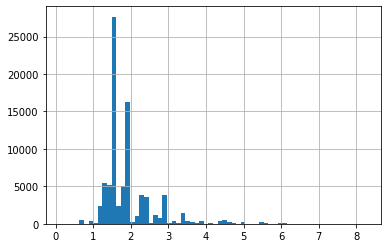

In [17]:
cars.engineDisplacement = cars.engineDisplacement.apply(lambda x: "1.6 LTR" if x=='undefined LTR' else x)
cars.engineDisplacement = cars.engineDisplacement.apply(lambda x: (re.sub(" LTR", "", x))).astype(float)
feature_info(cars.engineDisplacement)

### whilleType

In [18]:
feature_info(cars.whilleType)

Тип признака: object
Значения признака:


,whilleType
Левый,0.823
NaN,0.148
Правый,0.029


Различных значений c учётом NaN: 3
              	  без учёта NaN: 2 
Пропусков: 12564
Значений, встретившихся в столбце более 10 раз: 2


Пропуски образовались у новых автомобилей из-за особенностей разбора, заменим их на левый (новые автомобили в РФ только с левым рулём)

In [19]:
cars.whilleType.fillna('Левый', inplace=True)

In [20]:
feature_info(cars.whilleType)

Тип признака: object
Значения признака:


,whilleType
Левый,0.971
Правый,0.029


Различных значений c учётом NaN: 2
              	  без учёта NaN: 2 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 2


### drive

In [21]:
feature_info(cars.drive)

Тип признака: object
Значения признака:


,drive
передний,0.533
полный,0.269
Передний,0.083
Полный,0.061
задний,0.050
Задний,0.003
NaN,0.001
Автоматическая,0.000


Различных значений c учётом NaN: 8
              	  без учёта NaN: 7 
Пропусков: 56
Значений, встретившихся в столбце более 10 раз: 7


In [22]:
cars.drive = cars.drive.str.lower()
feature_info(cars.drive)

Тип признака: object
Значения признака:


,drive
передний,0.616
полный,0.331
задний,0.053
NaN,0.001
автоматическая,0.000


Различных значений c учётом NaN: 5
              	  без учёта NaN: 4 
Пропусков: 56
Значений, встретившихся в столбце более 10 раз: 4


### enginePower

In [23]:
feature_info(cars.enginePower)

Тип признака: object
Значения признака:


,enginePower
150 N12,0.078
123 N12,0.036
87 N12,0.031
105 N12,0.027
106 N12,0.027
...,...
351 N12,0.000
410 N12,0.000
363 N12,0.000
352 N12,0.000


Различных значений c учётом NaN: 386
              	  без учёта NaN: 386 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 248


In [24]:
cars.enginePower = cars.enginePower.apply(lambda x: (re.sub(" N12", "", x))).astype(int)

Тип признака: int32
Значения признака:


count    85077.000000
mean       144.032206
std         69.646517
min         12.000000
25%        101.000000
50%        125.000000
75%        163.000000
max        740.000000
Name: enginePower, dtype: float64

Различных значений c учётом NaN: 386
              	  без учёта NaN: 386 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 248


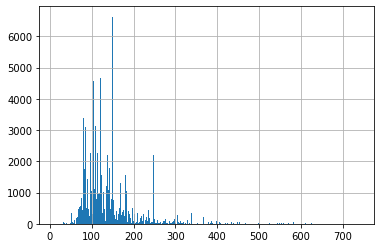

In [25]:
feature_info(cars.enginePower)

### href

In [26]:
feature_info(cars.href)

Тип признака: object
Значения признака:


,href
https://auto.ru/cars/used/sale/lifan/x50/1098688068-55f97b4d/,0.0
https://auto.ru/cars/used/sale/volkswagen/polo/1097136816-94640902/,0.0
https://auto.ru/cars/used/sale/vaz/2110/1098663500-7d6bec02/,0.0
https://auto.ru/cars/used/sale/ford/explorer/1097239730-4b02f1bc/,0.0
https://auto.ru/cars/used/sale/peugeot/206/1098855110-ecec8d8c/,0.0
...,...
https://auto.ru/cars/new/group/vaz/granta/21575585/21575593/1097045632-ad6daf01/,0.0
https://auto.ru/cars/used/sale/renault/logan/1098572110-9e554f59/,0.0
https://auto.ru/cars/used/sale/suzuki/swift/1094529742-640ba07e/,0.0
https://auto.ru/cars/used/sale/opel/astra/1097836510-bbbf3d51/,0.0


Различных значений c учётом NaN: 84877
              	  без учёта NaN: 84877 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 0


### kmAge

In [27]:
feature_info(cars.kmAge)

Тип признака: object
Значения признака:


,kmAge
Новый,0.148
200 000 км,0.012
150 000 км,0.012
120 000 км,0.009
180 000 км,0.009
...,...
60 770 км,0.000
83 529 км,0.000
36 400 км,0.000
7 831 км,0.000


Различных значений c учётом NaN: 18991
              	  без учёта NaN: 18991 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 451


In [28]:
cars.kmAge = cars.kmAge.apply(lambda x: (re.sub("км", "", x)))
cars.kmAge = cars.kmAge.apply(lambda x: (re.sub("Новый", "0", x)))
cars.kmAge = cars.kmAge.apply(lambda x: (re.sub("\xa0", "", x))).astype(int)


Тип признака: int32
Значения признака:


count      85077.000000
mean      114043.356536
std        89751.984530
min            0.000000
25%        45000.000000
50%       107500.000000
75%       165000.000000
max      1000000.000000
Name: kmAge, dtype: float64

Различных значений c учётом NaN: 18991
              	  без учёта NaN: 18991 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 451


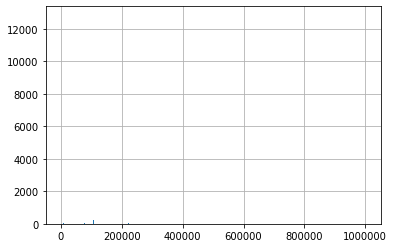

In [29]:
feature_info(cars.kmAge)

###  place

In [30]:
feature_info(cars.place)

Тип признака: object
Значения признака:


,place
Москва,0.077
Нижний Новгород,0.042
Волгоград,0.042
Санкт-Петербург,0.042
Уфа,0.042
...,...
Глазки,0.000
Россошь,0.000
Кашары,0.000
Песчанокопское,0.000


Различных значений c учётом NaN: 467
              	  без учёта NaN: 467 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 91


### VIN

In [31]:
feature_info(cars.VIN)

Тип признака: object
Значения признака:


,VIN
NaN,0.176
XTA**************,0.117
XW8**************,0.041
Z94**************,0.035
XWE**************,0.033
...,...
5FP**************,0.000
XUE**************,0.000
SX70-0***********,0.000
SXM157***********,0.000


Различных значений c учётом NaN: 770
              	  без учёта NaN: 769 
Пропусков: 15010
Значений, встретившихся в столбце более 10 раз: 177


In [32]:
cars.VIN.fillna('XXX', inplace=True)
cars.VIN = cars.VIN.apply(lambda x: (re.sub("\*", "", x)))
feature_info(cars.VIN)

Тип признака: object
Значения признака:


,VIN
XXX,0.176
XTA,0.117
XW8,0.041
Z94,0.035
XWE,0.033
...,...
MDH,0.000
1FD,0.000
EE1046,0.000
GS1510,0.000


Различных значений c учётом NaN: 770
              	  без учёта NaN: 770 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 178


### seller

In [33]:
feature_info(cars.seller)

Тип признака: object
Значения признака:


,seller
Private,0.564
БЦР MOTORS,0.005
КорсАвто Тула,0.005
Нижегородец Exchange на Комсомольском шоссе,0.004
Юг-Авто Эксперт Яблоновский,0.003
...,...
Лада-Центр Пулково,0.000
ТрансТехСервис Hyundai Уфа на Рубежной,0.000
Мерседес Автофорум,0.000
Автосалон GoodVIN,0.000


Различных значений c учётом NaN: 1590
              	  без учёта NaN: 1590 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 758


In [34]:
cars.seller = cars.seller.apply(lambda x: 'Salon' if x!='Private' else x)
feature_info(cars.seller)

Тип признака: object
Значения признака:


,seller
Private,0.564
Salon,0.436


Различных значений c учётом NaN: 2
              	  без учёта NaN: 2 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 2


### #owners

In [35]:
feature_info(cars['#owners'])

Тип признака: object
Значения признака:


,#owners
3 или более,0.385
1 владелец,0.256
2 владельца,0.212
0,0.148


Различных значений c учётом NaN: 4
              	  без учёта NaN: 4 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 4


Тип признака: int32
Значения признака:


count    85077.000000
mean         1.833751
std          1.097071
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: #owners, dtype: float64

Различных значений c учётом NaN: 4
              	  без учёта NaN: 4 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 4


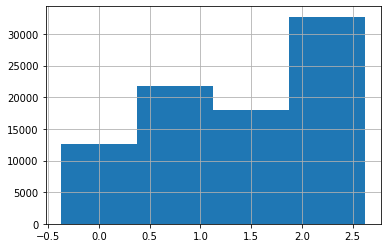

In [36]:
cars['#owners'] = cars['#owners'].apply(lambda x: (re.sub("\D", "", x))).astype(int)
feature_info(cars['#owners'])

### inUse

In [37]:
feature_info(cars.inUse)

Тип признака: object
Значения признака:


,inUse
0,0.673
1 год и 6 месяцев,0.006
10 месяцев,0.006
1 год,0.006
1 год и 10 месяцев,0.005
...,...
28 лет и 4 месяца,0.000
31 год и 11 месяцев,0.000
31 год и 6 месяцев,0.000
44 года и 5 месяцев,0.000


Различных значений c учётом NaN: 306
              	  без учёта NaN: 306 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 174


In [38]:
def reshape_years(inuse):
    word = inuse.split(sep=' ')
    years = 0
    months = 0

    if len(word) >= 2:
        for i in range(0, len(word)):
            if word[i].isdigit() and word[i + 1][:3] == 'мес':
                months = int(word[i])
            elif word[i].isdigit() and (word[i + 1][:3] == 'лет' or word[i + 1][:3] == 'год'):
                years = int(word[i])
    return (years * 12 + months)   
    
cars['inUse']=cars.inUse.apply(reshape_years)

Тип признака: int64
Значения признака:


count    85077.000000
mean        16.705667
std         34.548411
min          0.000000
25%          0.000000
50%          0.000000
75%         18.000000
max        610.000000
Name: inUse, dtype: float64

Различных значений c учётом NaN: 306
              	  без учёта NaN: 306 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 174


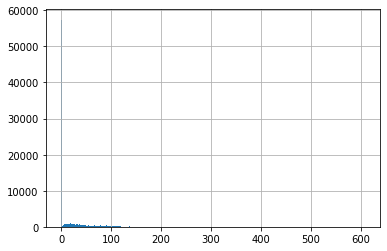

In [39]:
feature_info(cars.inUse)

### pts

In [40]:
feature_info(cars.pts)

Тип признака: object
Значения признака:


,pts
Оригинал,0.750
NaN,0.148
Дубликат,0.103


Различных значений c учётом NaN: 3
              	  без учёта NaN: 2 
Пропусков: 12564
Значений, встретившихся в столбце более 10 раз: 2


In [41]:
cars.pts.fillna('Оригинал', inplace=True)
feature_info(cars.pts)

Тип признака: object
Значения признака:


,pts
Оригинал,0.897
Дубликат,0.103


Различных значений c учётом NaN: 2
              	  без учёта NaN: 2 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 2


### condition

In [42]:
feature_info(cars.condition)

Тип признака: object
Значения признака:


,condition
Не требует ремонта,0.852
NaN,0.148


Различных значений c учётом NaN: 2
              	  без учёта NaN: 1 
Пропусков: 12564
Значений, встретившихся в столбце более 10 раз: 1


In [43]:
cars.condition.fillna('Другое',inplace=True)

### tax

In [44]:
feature_info(cars.tax)

Тип признака: object
Значения признака:


,tax
5 250 ₽ / год,0.018
18 675 ₽ / год,0.014
4 500 ₽ / год,0.010
3 750 ₽ / год,0.009
0 ₽ / год,0.008
...,...
34 000 ₽ / год,0.000
77 100 ₽ / год,0.000
1 484 ₽ / год,0.000
45 875 ₽ / год,0.000


Различных значений c учётом NaN: 2761
              	  без учёта NaN: 2761 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 1195


Тип признака: int32
Значения признака:


count     85077.000000
mean       7259.786676
std       15756.175715
min           0.000000
25%        1548.000000
50%        3210.000000
75%        5520.000000
max      400294.000000
Name: tax, dtype: float64

Различных значений c учётом NaN: 2760
              	  без учёта NaN: 2760 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 1194


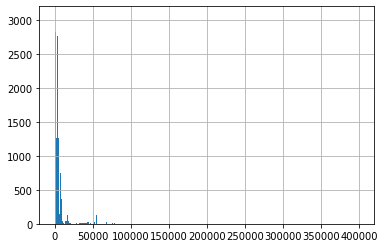

In [45]:
cars.tax = cars.tax.apply(lambda x: (re.sub("\D", "", x))).astype(int)
feature_info(cars.tax)

### castoms

In [46]:
feature_info(cars.castoms)

Тип признака: object
Значения признака:


,castoms
Растаможен,0.852
NaN,0.148


Различных значений c учётом NaN: 2
              	  без учёта NaN: 1 
Пропусков: 12564
Значений, встретившихся в столбце более 10 раз: 1


In [47]:
cars.castoms.fillna('Другое',inplace=True)

### exchange

In [48]:
feature_info(cars.exchange)

Тип признака: object
Значения признака:


,exchange
NaN,0.685
Рассмотрю варианты,0.315


Различных значений c учётом NaN: 2
              	  без учёта NaN: 1 
Пропусков: 58238
Значений, встретившихся в столбце более 10 раз: 1


In [49]:
cars.exchange.fillna('Нет',inplace=True)

### price

Тип признака: int64
Значения признака:


count    8.507700e+04
mean     9.216478e+05
std      1.319827e+06
min      1.000000e+04
25%      3.000000e+05
50%      5.500000e+05
75%      1.000000e+06
max      8.500000e+07
Name: price, dtype: float64

Различных значений c учётом NaN: 8358
              	  без учёта NaN: 8358 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 959


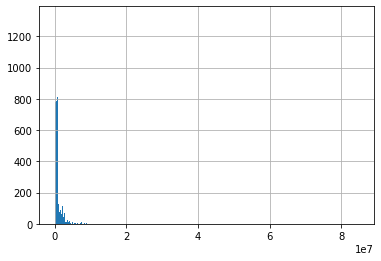

In [50]:
feature_info(cars.price)

In [51]:
cars.drop(['priceCurrency','href', 'index'], axis=1, inplace=True)

In [52]:
cars.head(10)

,brand,name,modelDate,color,productionDate,bodyType,fuelType,numberOfDoors,vehicleTransmission,engineDisplacement,whilleType,drive,enginePower,kmAge,place,VIN,seller,#owners,inUse,pts,condition,tax,castoms,exchange,price
0,SKODA,Skoda Octavia III (A7),2013,чёрный,2015,универсал,бензин,5,роботизированная,1.8,Левый,полный,180,116000,Пушкино,TMB,Private,1,0,Оригинал,Не требует ремонта,8820,Растаможен,Нет,1350000
1,FORD,Ford Focus II Рестайлинг,2007,чёрный,2008,седан,бензин,4,механическая,1.8,Левый,передний,125,152000,Москва,WF0,Salon,3,0,Оригинал,Не требует ремонта,3125,Растаможен,Рассмотрю варианты,319000
2,BMW,BMW X3 II (F25) 20d xDrive,2010,синий,2014,внедорожник,дизель,5,автоматическая,2.0,Левый,полный,184,134215,Москва,X4X,Private,1,0,Оригинал,Не требует ремонта,9200,Растаможен,Нет,1271000
3,VAZ,LADA (ВАЗ) Kalina I,2004,чёрный,2009,универсал,бензин,5,механическая,1.6,Левый,передний,81,17372,Москва,XTA,Private,2,0,Оригинал,Не требует ремонта,972,Растаможен,Рассмотрю варианты,300000
4,AUDI,Audi Q7 II (4M) Рестайлинг 45 TDI,2019,коричневый,2020,внедорожник,дизель,5,автоматическая,3.0,Левый,полный,249,0,Москва,XXX,Salon,0,0,Оригинал,Другое,18675,Другое,Нет,4805000
5,DATSUN,Datsun mi-DO,2015,оранжевый,2015,хэтчбек,бензин,5,автоматическая,1.6,Левый,передний,87,104000,Москва,Z8N,Salon,2,0,Оригинал,Не требует ремонта,1044,Растаможен,Нет,295000
6,VAZ,LADA (ВАЗ) 2114,2001,серебристый,2005,хэтчбек,бензин,5,механическая,1.5,Левый,передний,77,147500,Москва,XTA,Private,3,0,Дубликат,Не требует ремонта,924,Растаможен,Нет,59000
7,FORD,Ford C-MAX I,2003,зелёный,2005,компактвэн,бензин,5,автоматическая,2.0,Левый,передний,145,170000,Москва,WF0,Private,3,0,Оригинал,Не требует ремонта,5075,Растаможен,Нет,285000
8,TOYOTA,Toyota Matrix I (E130),2002,белый,2003,хэтчбек,бензин,5,механическая,1.8,Левый,передний,183,181000,Москва,2T1,Private,3,0,Оригинал,Не требует ремонта,9150,Растаможен,Нет,275000
9,NISSAN,Nissan Murano I (Z50),2002,пурпурный,2007,внедорожник,бензин,5,вариатор,3.5,Левый,полный,234,80000,Москва,JN1,Private,2,0,Оригинал,Не требует ремонта,17550,Растаможен,Нет,450000


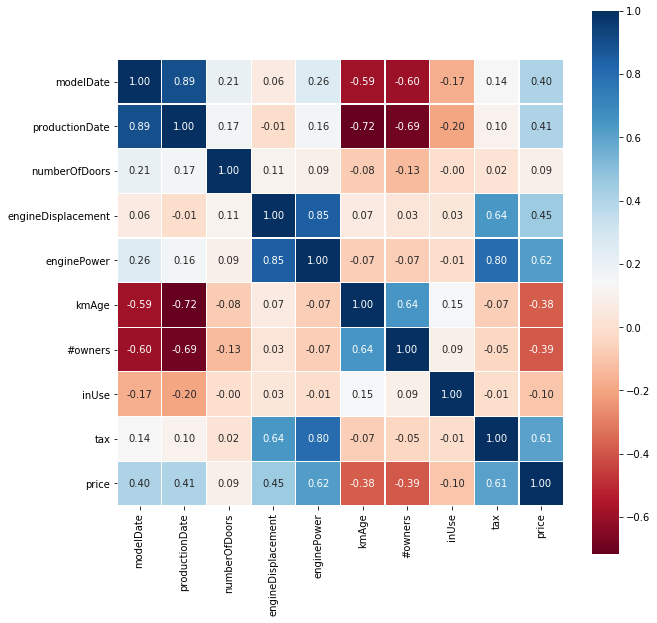

In [53]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cars.corr(), square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu")

Выводы: очень сильная корреляция: modelDate:productionDate, :kmAge, :#owners
                                  productionDate:modelDate, :kmAge, :#owners
                                  engineDisplacement:enginePower, tax
                                  kmAge:productionDate, :#owners

In [58]:
cars.to_csv('d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\200620_auto_bd_cleared.csv', sep=';', encoding='utf-8')

In [54]:
# Функция для поиска статистически значимых различий
def get_stat_dif(_column, _result_mark):
    cols = cars.loc[:, _column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(cars.loc[cars.loc[:, _column] == comb[0], _result_mark], 
                        cars.loc[cars.loc[:, _column] == comb[1], _result_mark]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', _column)
            break

In [55]:
# Функция для визуализации зависимостей категориальных признаков
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='price', 
                data=cars,
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

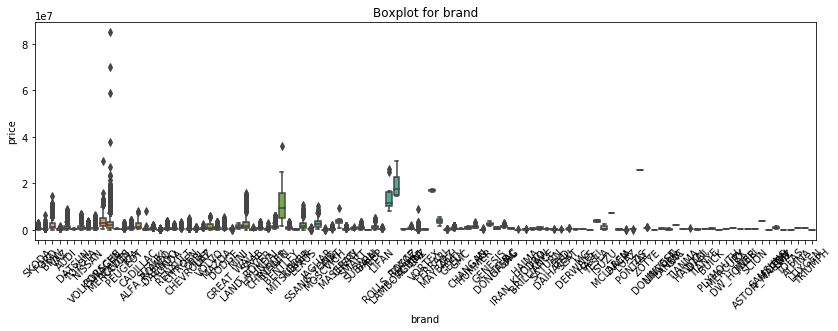

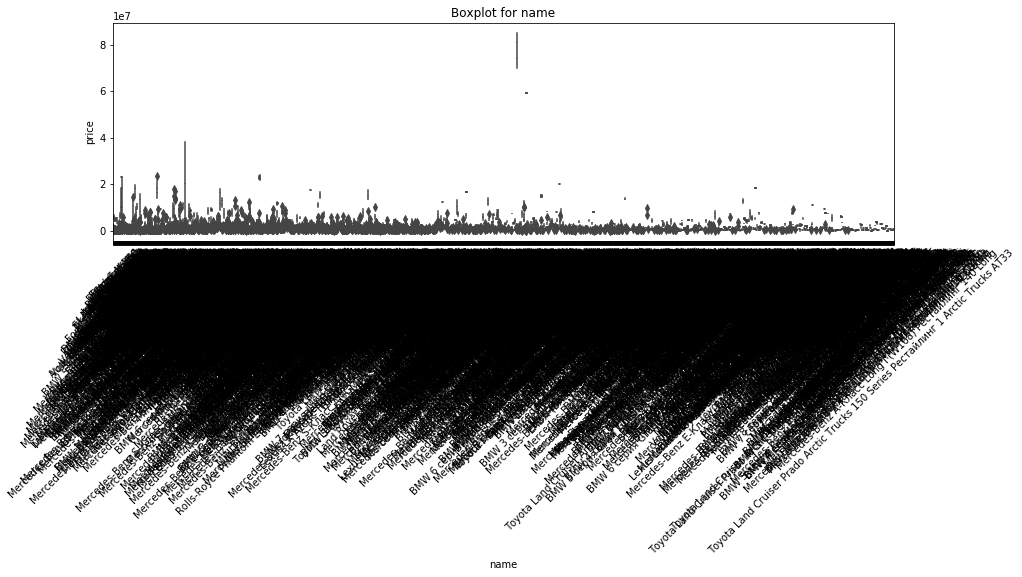

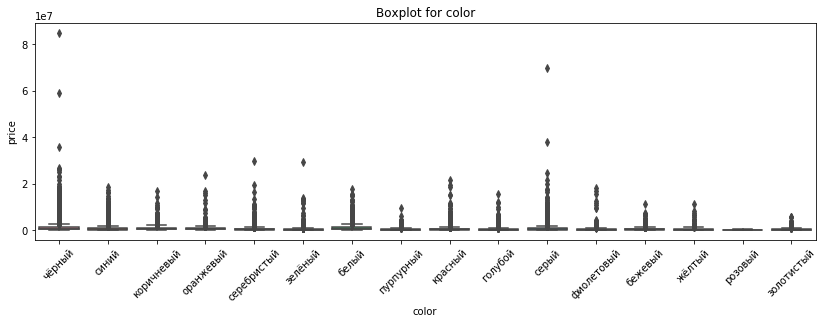

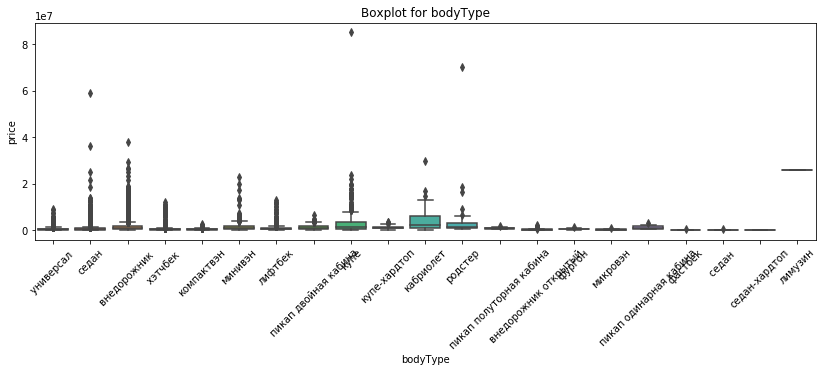

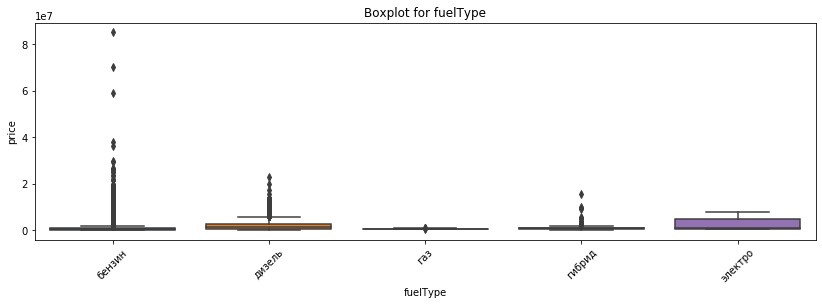

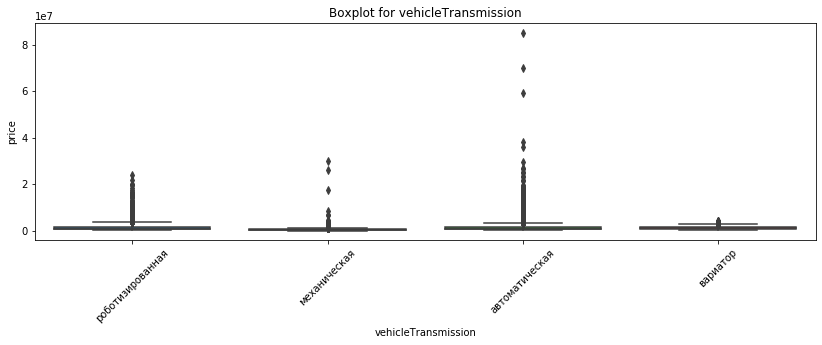

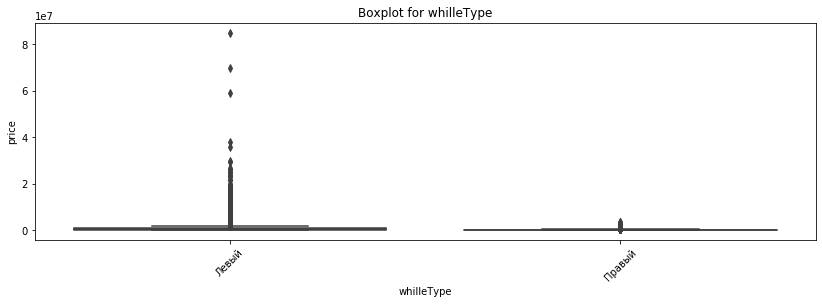

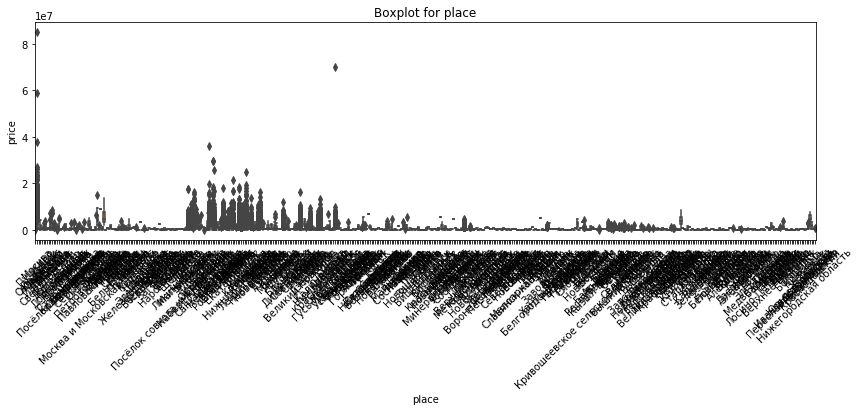

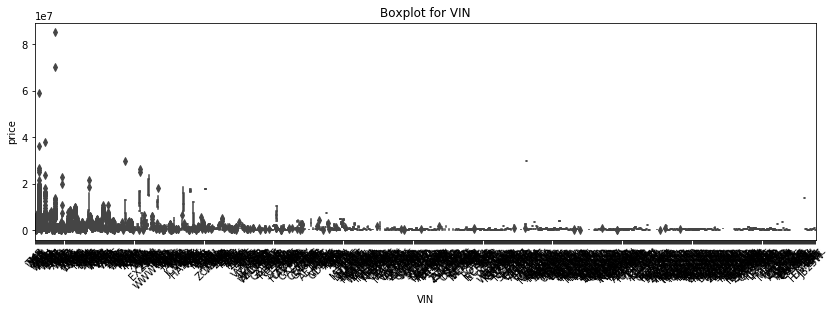

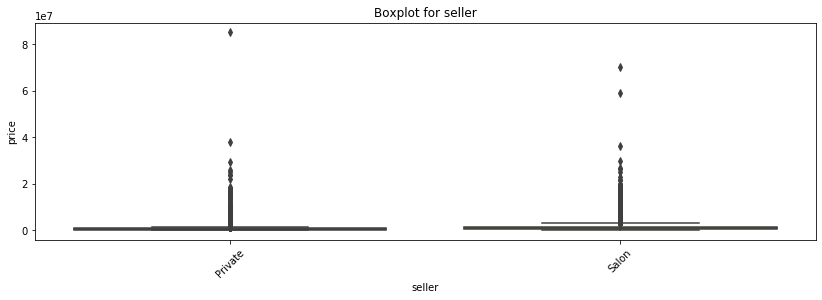

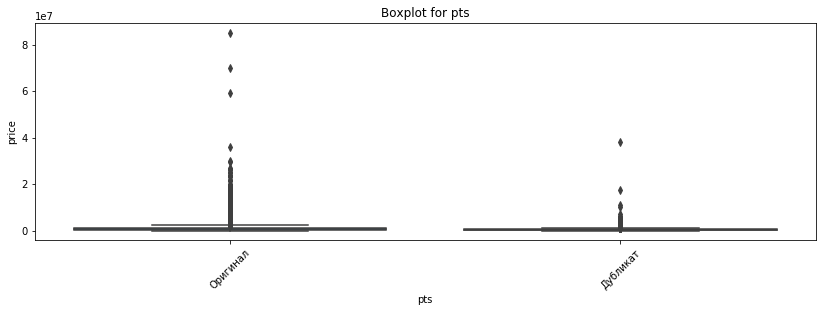

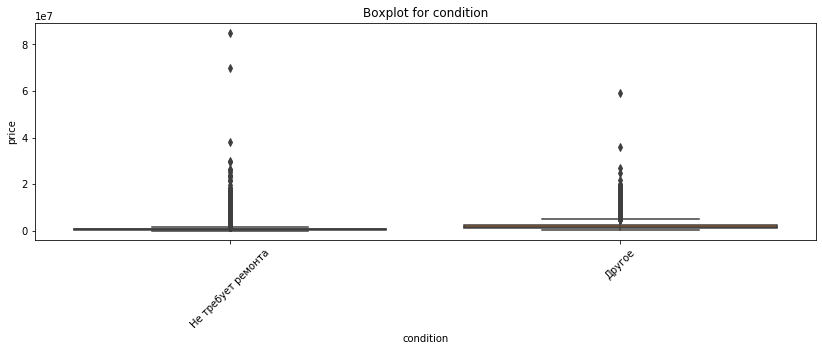

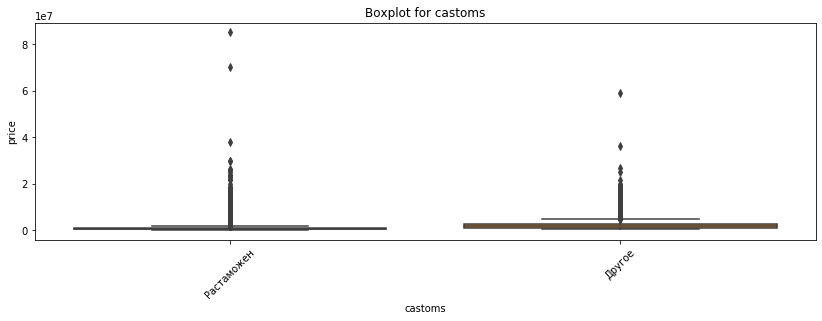

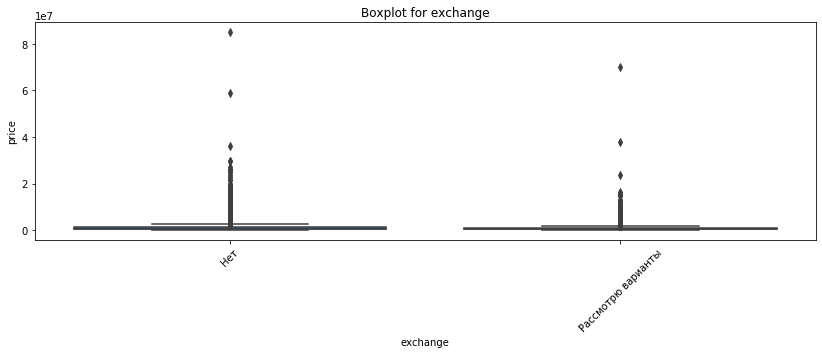

In [56]:
for col in ['brand', 'name', 'color', 'bodyType', 'fuelType', 'vehicleTransmission', 'whilleType', 'place', 'VIN',
            'seller', 'pts', 'condition', 'castoms', 'exchange']:
    get_boxplot(col)

In [57]:
for col in ['brand', 'name', 'color', 'bodyType', 'fuelType', 'vehicleTransmission', 'whilleType', 'place', 'VIN',
            'seller', 'pts', 'condition', 'castoms', 'exchange']:
    get_stat_dif(col, 'price')

Найдены статистически значимые различия для колонки brand
Найдены статистически значимые различия для колонки name
Найдены статистически значимые различия для колонки color
Найдены статистически значимые различия для колонки bodyType
Найдены статистически значимые различия для колонки fuelType
Найдены статистически значимые различия для колонки vehicleTransmission
Найдены статистически значимые различия для колонки whilleType
Найдены статистически значимые различия для колонки place
Найдены статистически значимые различия для колонки VIN
Найдены статистически значимые различия для колонки seller
Найдены статистически значимые различия для колонки pts
Найдены статистически значимые различия для колонки condition
Найдены статистически значимые различия для колонки castoms
Найдены статистически значимые различия для колонки exchange
